# Job characteristics analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read logs

In [2]:
job_chars = pd.read_parquet('data/job_chars.parquet')

In [3]:
job_chars

,Batch_class,Submission_date,Waited,Start_date,Duration,Nodes,CPU,Memory,delta_CPU,delta_Memory
index,,,,,,,,,,
000030ecd19c9c04,feque,2020-02-18 11:14:38+01:00,29.916667,2020-02-18 11:44:33+01:00,1.450000,1.0,0.168851,0.31349,0.000000,0.000000
00020fcd04947084,clexpres,2020-05-30 11:50:05+02:00,5.383333,2020-05-30 11:55:28+02:00,4.700000,2.0,31.315993,2.02000,0.000000,0.000000
0002286e1d7e428d,clmedium,NaT,NaN,2020-09-28 07:55:47+02:00,60.716667,1.0,0.989072,0.04895,0.502306,0.005687
00024ec1bf68e413,clfo2,NaT,NaN,2020-06-29 01:05:19+02:00,0.116667,1.0,0.000000,0.00000,0.000000,0.000000
00027e89035bec8d,clmedium,2020-03-25 21:22:02+01:00,38.783333,2020-03-25 22:00:49+01:00,1.283333,1.0,21.721169,131.76000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
fffbfaccf8c9fbf4,clexpres,NaT,NaN,2020-03-27 15:05:44+01:00,5.033333,1.0,0.190265,0.11484,0.000000,0.000000
fffd086716a4d46c,cllong,NaT,NaN,2020-09-14 00:40:27+02:00,143.616667,1.0,0.994714,0.46693,0.025502,0.000300
ffff38341e8c6b3b,clmedium,2020-08-13 22:35:57+02:00,401.333333,2020-08-14 05:17:17+02:00,621.766667,8.0,31.858035,5.24000,0.662259,0.550000


In [4]:
detected_waiting_time = job_chars['Waited'].notna()

In [5]:
#Masks to separate queue type: 'clexpres', 'clmedium', 'cllong', 'clbigmem', 'clfo2'
batch_classes = ['clexpres', 'clmedium', 'cllong', 'clbigmem', 'clfo2','feque']

In [11]:
def daily_cycle_mean(df, queue_name, column):
    queues = df.loc[df['Batch_class'].str.contains(queue_name)]
    hourly = queues.groupby(queues['Submission_date'].dt.hour)[column].mean()
    return(hourly)

def weekly_cycle_mean(df, queue_name, column):
    week   = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    queues = df.loc[df['Batch_class'].str.contains(queue_name)]
    weekly = queues.groupby(queues['Submission_date'].dt.day_name())[column].mean().reindex(week)
    return(weekly)

In [12]:
def histogram_dataframe(df, batch_classes, weekly = False):
    waiting_time = {}
    axis   = 'Hour'
    for batch_class in batch_classes:
        if weekly:
            waiting_time[batch_class] = weekly_cycle_mean(df, batch_class, 'Waited')
            axis = 'Day'
        else:
            waiting_time[batch_class] = daily_cycle_mean(df, batch_class, 'Waited')
            
        
    waiting_time_df = pd.DataFrame(waiting_time).rename_axis(axis)
    return(waiting_time_df)

Text(0, 0.5, 'Waiting times in hours')

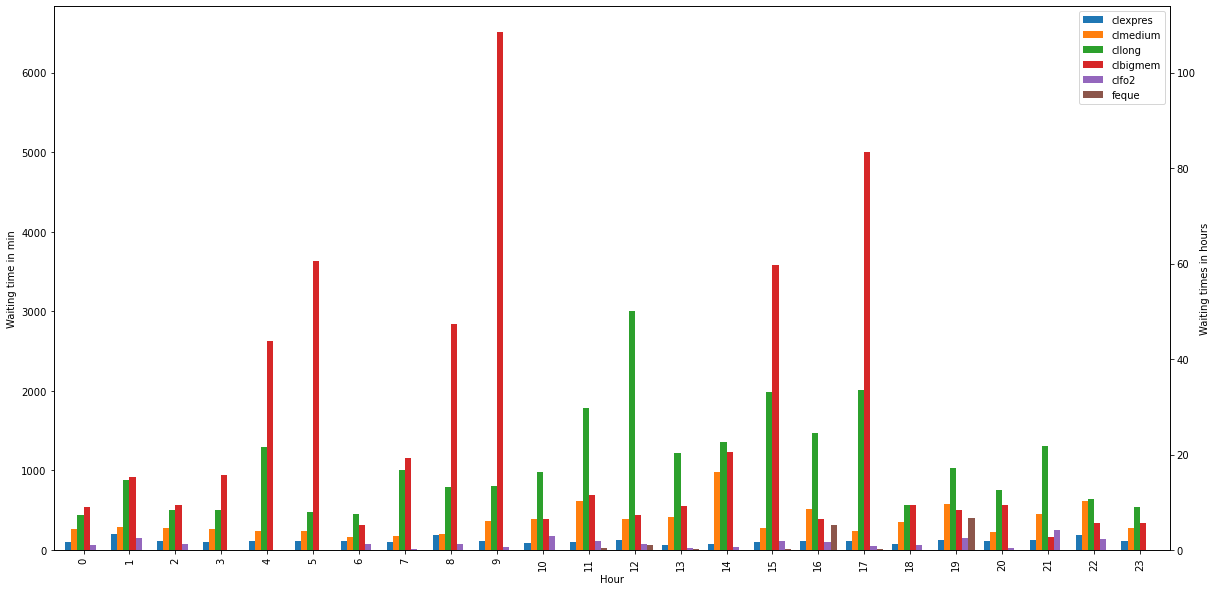

In [13]:
ax1 = histogram_dataframe(job_chars[detected_waiting_time], batch_classes).plot.bar(figsize=(20,10),width=0.8,ylabel='Waiting time in min')
ax2 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn/60, mx/60)
ax2.set_ylabel('Waiting times in hours')

Text(0, 0.5, 'Waiting times in hours')

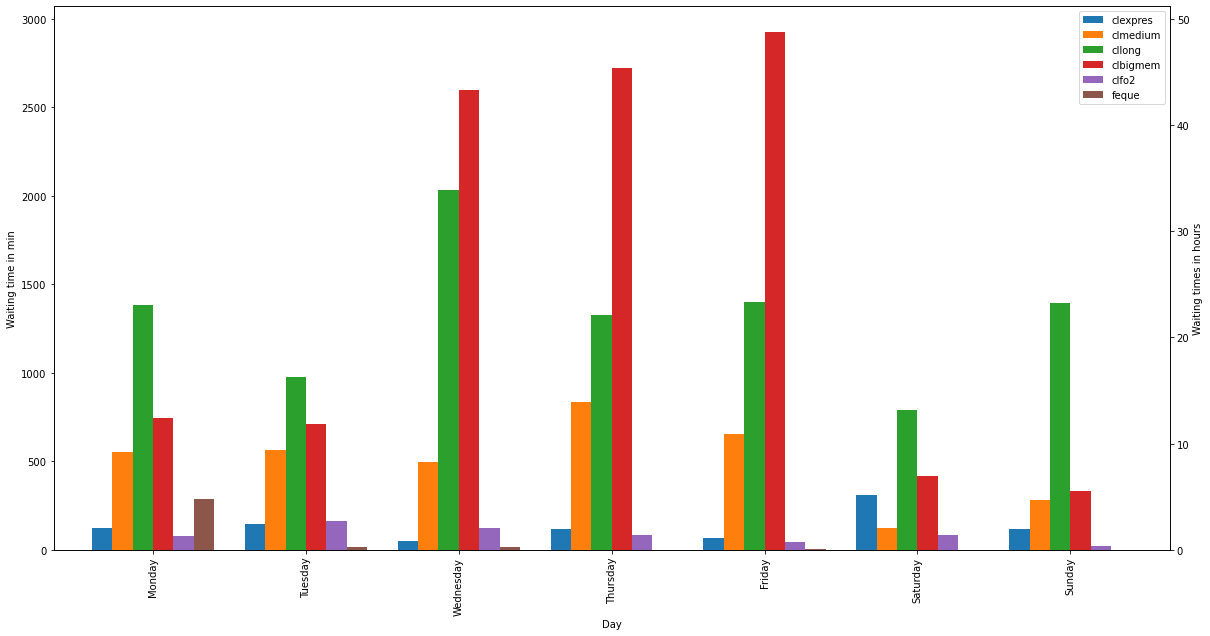

In [14]:
ax1 = histogram_dataframe(job_chars[detected_waiting_time], batch_classes,weekly=True).plot.bar(figsize=(20,10),width=0.8,ylabel='Waiting time in min')
ax2 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax2.set_ylim(mn/60, mx/60)
ax2.set_ylabel('Waiting times in hours')

## Waiting time distributions grouped by hour or weekday of submission

In [6]:
def grouping_cycle(df):
    df_new                  = df.reset_index()
    df_new['Weekday']       = df_new['Submission_date'].dt.day_name()
    df_new['Hour']          = df_new['Submission_date'].dt.hour
    weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    #Assign the above list to category ranking
    wDays = pd.api.types.CategoricalDtype(ordered= True, categories=weekday)
    #Apply this to the specific column in DataFrame
    df_new['Weekday'] = df_new['Weekday'].astype(wDays)
    return(df_new[['Waited','Batch_class','Weekday','Hour']])

In [87]:
def Box_plot(df,batch_class, week=False, whiskers=(10,90),wcolor='black',bcolor='black',mcolor='darkred'):
    wprops  = dict(color=wcolor)
    bprops  = dict(color=bcolor)
    mprops  = dict(color=mcolor,linewidth=4)
    df['Waited'] = df['Waited']/60
    if week:
        ax1 = df.loc[df['Batch_class'].str.contains(batch_class)].boxplot(
            column='Waited',by='Weekday',whis=whiskers,showfliers=False,
            boxprops=bprops,whiskerprops=wprops,medianprops=mprops,figsize=(20,10)
        )
        count = pd.DataFrame(df.loc[df['Batch_class'].str.contains(batch_class)].groupby('Weekday')['Waited'].agg('count'))
    else:
        ax1 = df.loc[df['Batch_class'].str.contains(batch_class)].boxplot(
            column='Waited',by='Hour',whis=whiskers,showfliers=False,
            boxprops=bprops,whiskerprops=wprops,medianprops=mprops,figsize=(20,10)
        )
        count = pd.DataFrame(df.loc[df['Batch_class'].str.contains(batch_class)].groupby('Hour')['Waited'].agg('count'))
        
    ax1.set_ylabel('Waiting times in hours')
    ax1.set_title(batch_class)
    ax2 = ax1.twinx()
    count['Waited'].plot.bar(ax=ax2,alpha=0.1,color='midnightblue')
    ax2.set_ylabel('Number of values used for statistic',color='midnightblue')
    ax2.tick_params(axis='y', labelcolor='midnightblue')
    plt.show()
    

## Hourly waiting time distributions

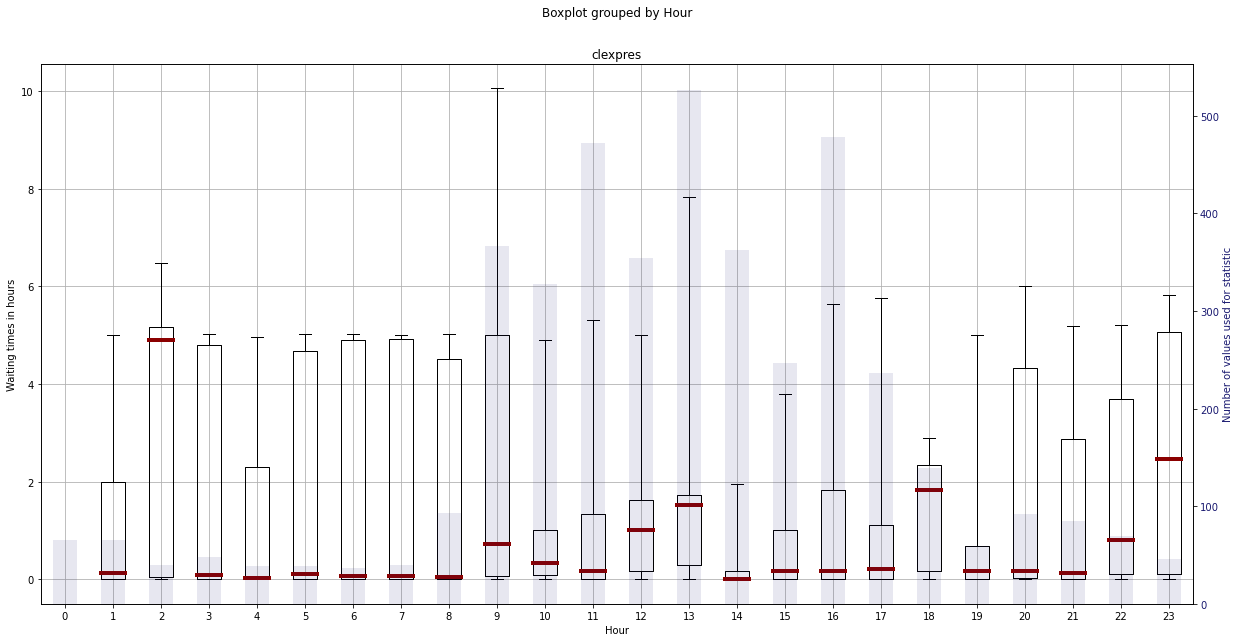

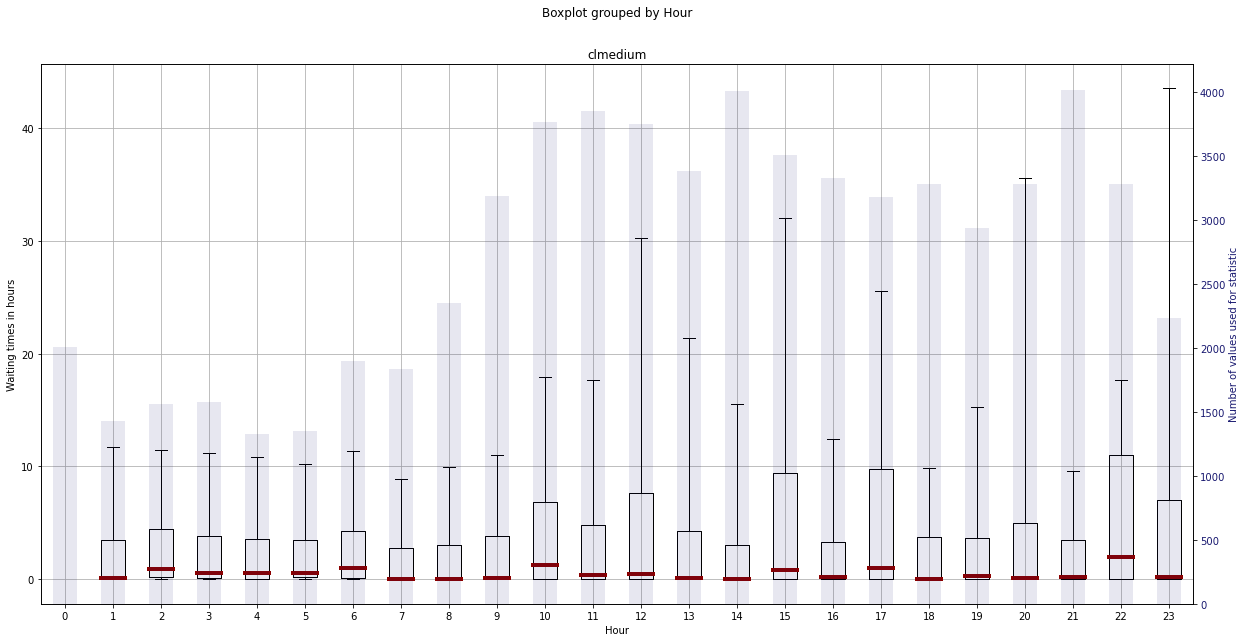

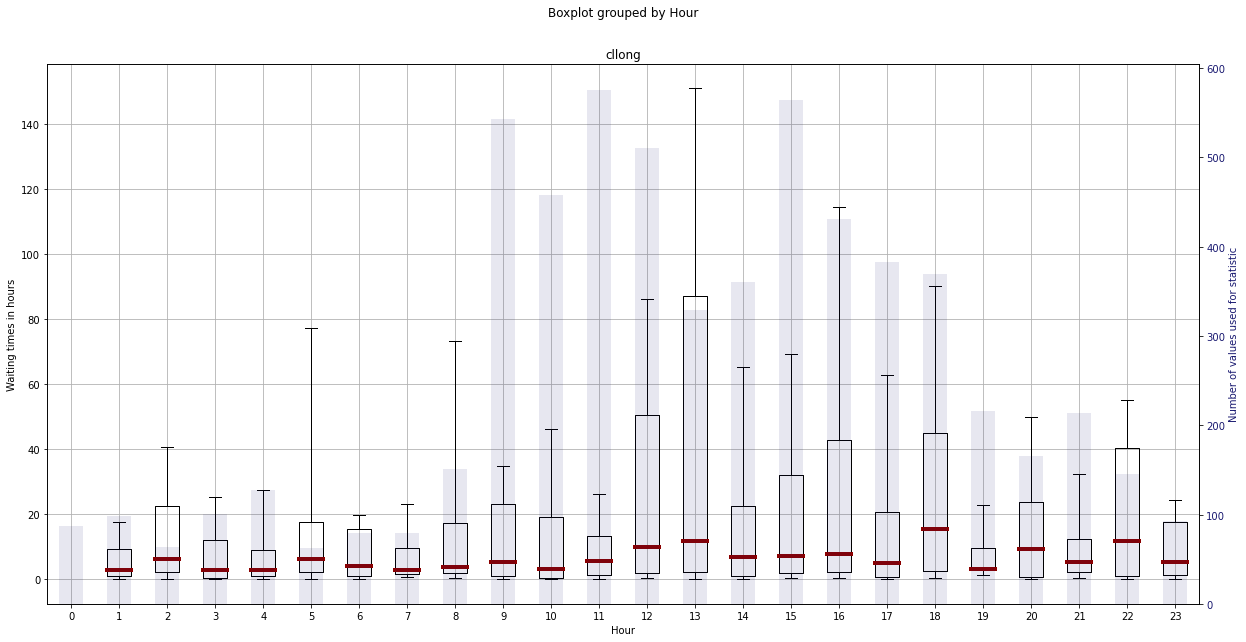

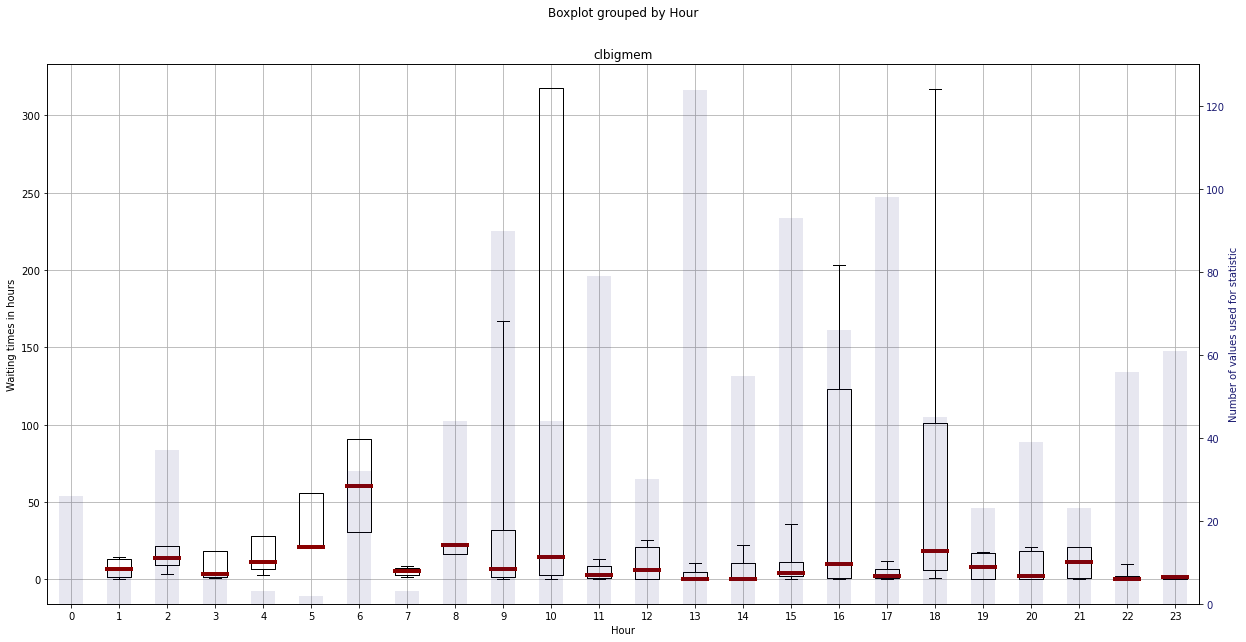

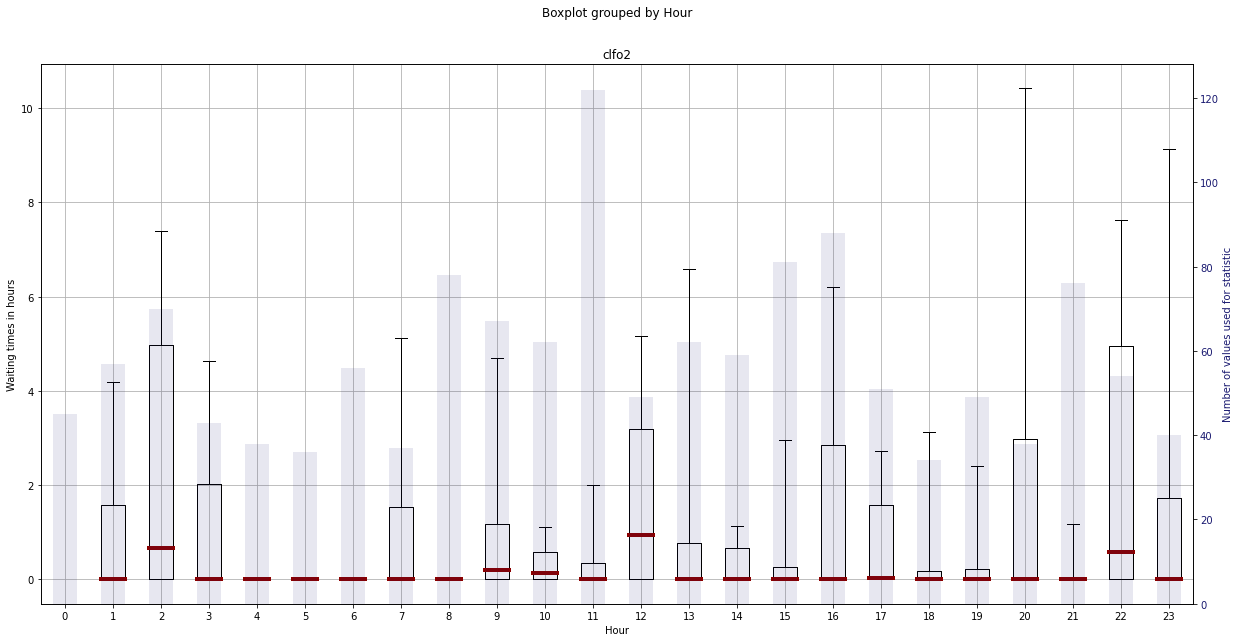

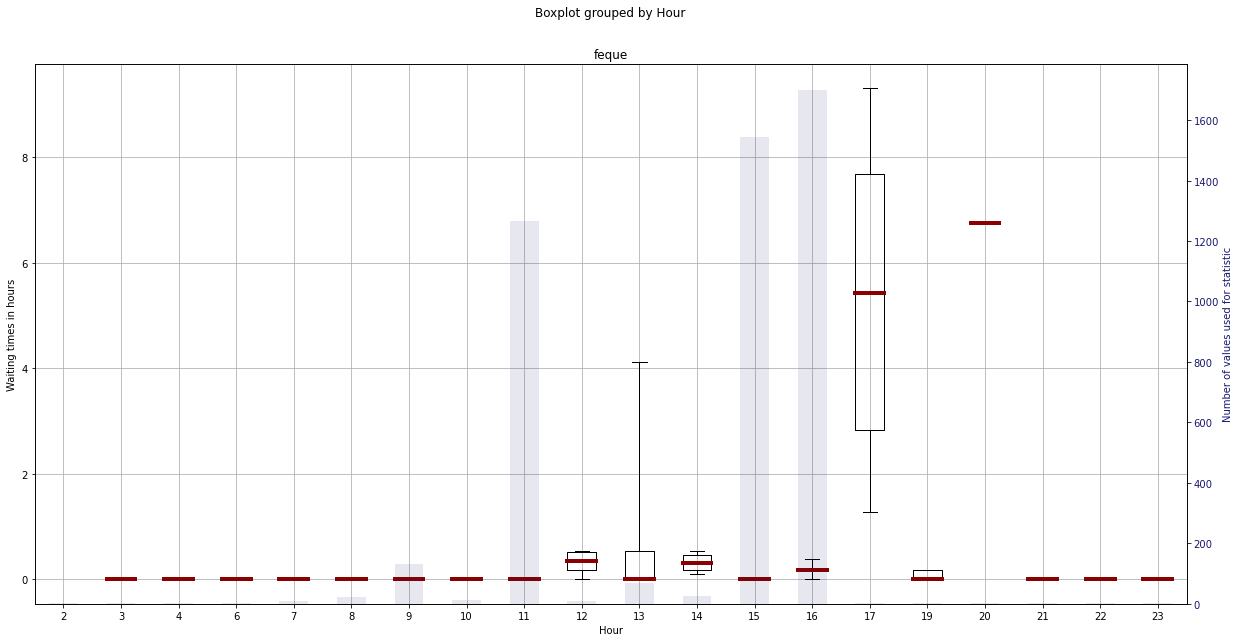

In [88]:
for batch_class in batch_classes:
    Box_plot(grouping_cycle(job_chars[detected_waiting_time]),batch_class)

## Weekly waiting time distributions

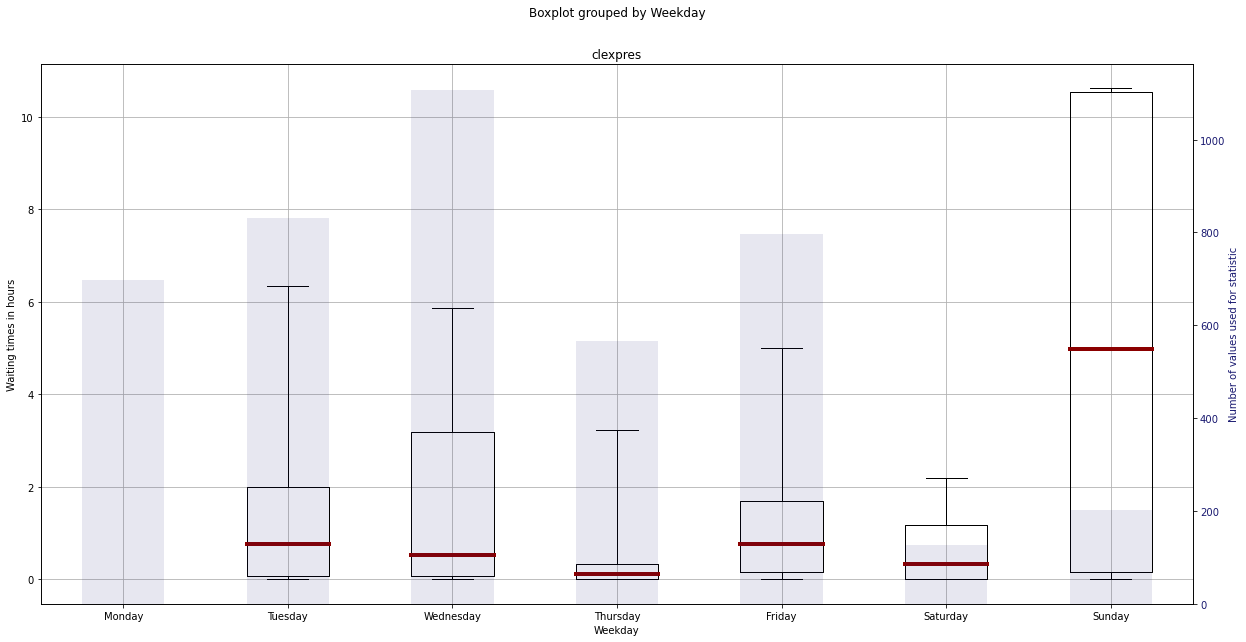

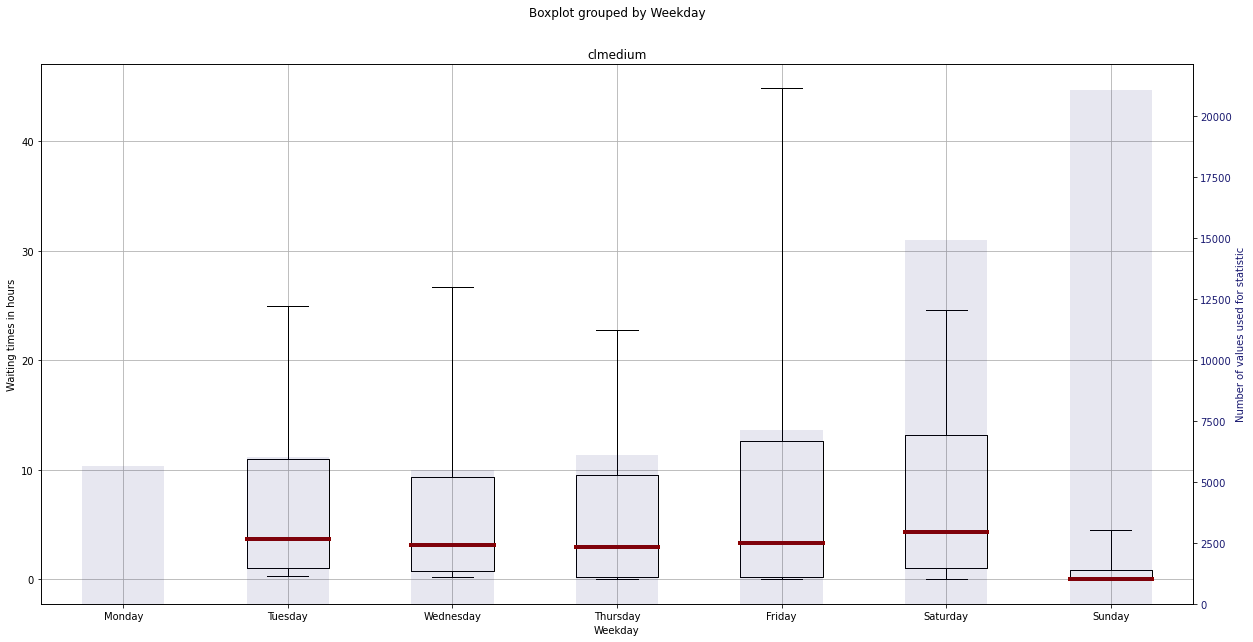

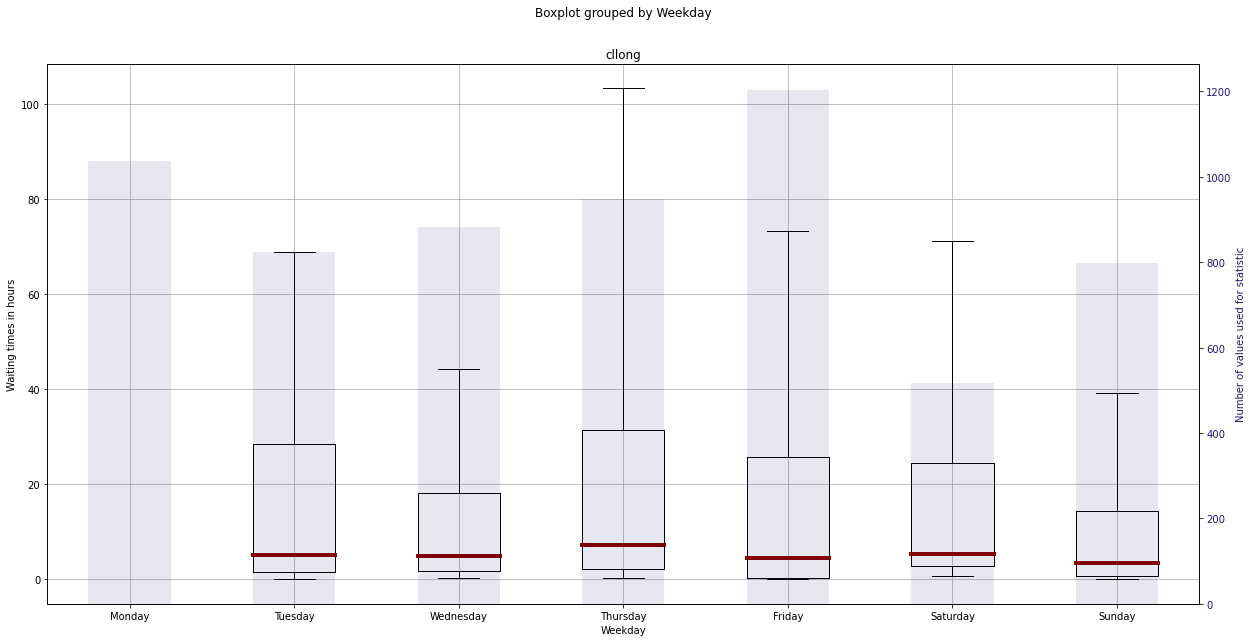

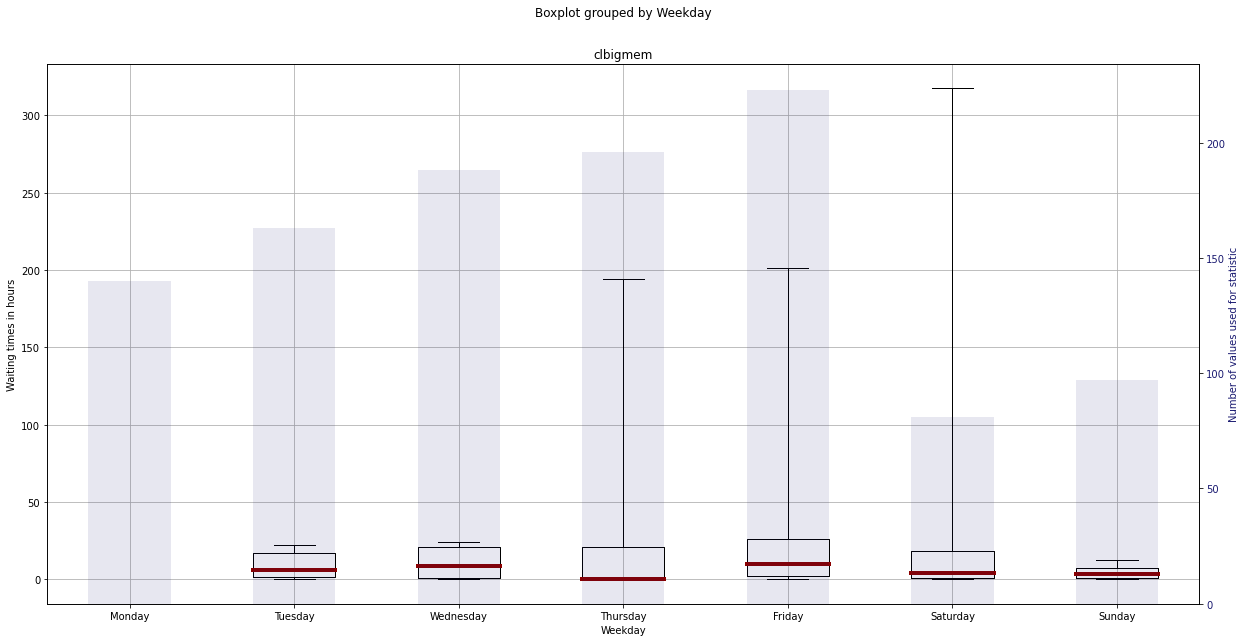

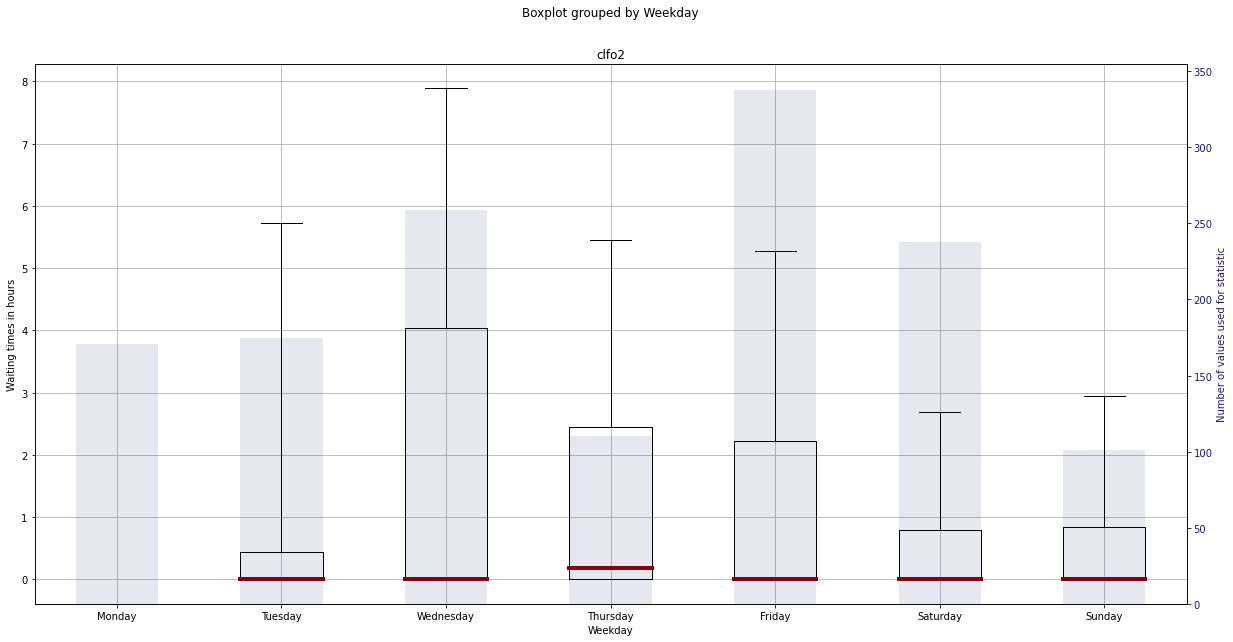

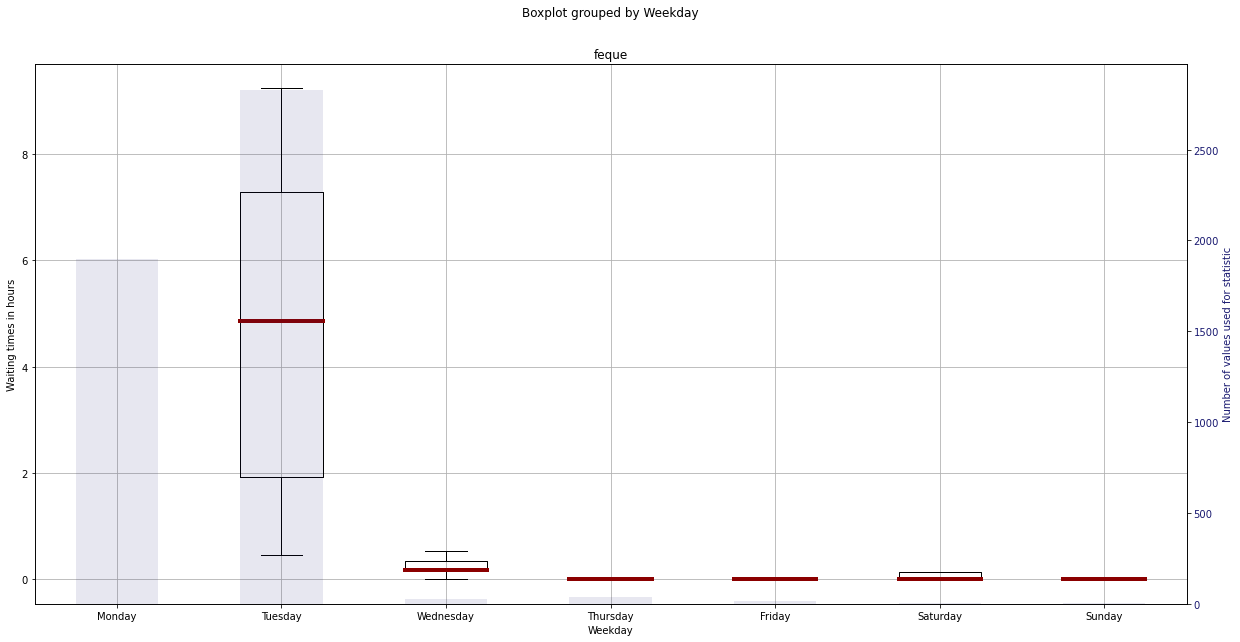

In [89]:
for batch_class in batch_classes:
    Box_plot(grouping_cycle(job_chars[detected_waiting_time]),batch_class,week=True)

In [26]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/git-lfs-2.11.0-0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/nomkl-1.0-h5ca1d4c_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-conda_forge.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2020.6.20-hecda079_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.35-h769bd43_9.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran5-9.3.0-he4bcb1c_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.3.0-h2ae2ef3_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/pandoc-2.11.0.4-hd18ef5c_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-9.3.0-he4bcb1c_17.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgomp-9.3.0-h5dbcf3e_17.tar.bz2
https://conda.anacon